In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
normal_traffic_dataset = pd.read_csv('/content/CTU13_Normal_Traffic.csv')
attack_traffic_dataset = pd.read_csv('/content/CTU13_Attack_Traffic.csv')

# Combine normal traffic and attack traffic dataset
dataset = pd.concat([normal_traffic_dataset, attack_traffic_dataset], ignore_index=True)

# Separate features and labels
X = dataset.drop(columns=['Label'])
y = dataset['Label']

# Split the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Normalize the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler for later use in deployment
import joblib
joblib.dump(scaler, 'scaler.pkl')

# Define the Autoencoder model
@tf.keras.saving.register_keras_serializable()
class Autoencoder(Model):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Sequential([
            Dense(128, activation="relu", input_shape=(input_dim,)),
            Dense(64, activation="relu"),
            Dense(32, activation="relu"),
            Dense(16, activation="relu"),
            Dense(8, activation="relu")
        ])
        self.decoder = Sequential([
            Dense(16, activation="relu", input_shape=(8,)),
            Dense(32, activation="relu"),
            Dense(64, activation="relu"),
            Dense(128, activation="relu"),
            Dense(input_dim, activation="sigmoid")
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

input_dim = X_train_scaled.shape[1]
autoencoder = Autoencoder(input_dim)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Train the Autoencoder
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    shuffle=True,
    callbacks=[early_stopping]
)

Epoch 1/100
1729/1729 [==============================] - 11s 5ms/step - loss: 0.0142 - val_loss: 0.0027
Epoch 2/100
1729/1729 [==============================] - 9s 5ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 3/100
1729/1729 [==============================] - 7s 4ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 4/100
1729/1729 [==============================] - 9s 5ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 5/100
1729/1729 [==============================] - 9s 5ms/step - loss: 0.0010 - val_loss: 7.8149e-04
Epoch 6/100
1729/1729 [==============================] - 8s 4ms/step - loss: 7.6671e-04 - val_loss: 6.9972e-04
Epoch 7/100
1729/1729 [==============================] - 9s 5ms/step - loss: 6.6763e-04 - val_loss: 5.9109e-04
Epoch 8/100
1729/1729 [==============================] - 7s 4ms/step - loss: 6.1814e-04 - val_loss: 5.6856e-04
Epoch 9/100
1729/1729 [==============================] - 9s 5ms/step - loss: 4.7401e-04 - val_loss: 3.7427e-04
Epoch 10/100
1729/1729 [============

721/721 [==============================] - 1s 2ms/step
Threshold: 0.002720581841115642
Test MSE Mean: 0.00020059450586665077, Test MSE Std: 0.0010207276349630061
Number of anomalies in test set: 223


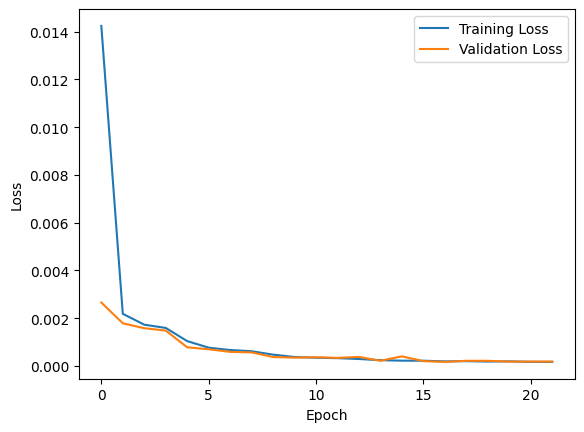

In [4]:
# Calculate Mean Squared Error (MSE) for reconstruction
reconstructed_train = autoencoder.predict(X_train_scaled)
mse_train = np.mean(np.square(X_train_scaled - reconstructed_train), axis=1)

# Determine the threshold for anomaly detection
threshold = np.mean(mse_train) + 3 * np.std(mse_train)

# Evaluate the model
reconstructed_test = autoencoder.predict(X_test_scaled)
mse_test = np.mean(np.square(X_test_scaled - reconstructed_test), axis=1)
anomalies = mse_test > threshold

# Print evaluation results
print(f"Threshold: {threshold}")
print(f"Test MSE Mean: {np.mean(mse_test)}, Test MSE Std: {np.std(mse_test)}")
print(f"Number of anomalies in test set: {np.sum(anomalies)}")

# Plot the training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [5]:
!pip install modelbit

In [14]:
import numpy as np
import tensorflow as tf
import joblib
import modelbit as mb

# Load the trained autoencoder model and scaler once
model = tf.keras.models.load_model('autoencoder_model.keras')
scaler = joblib.load('scaler.pkl')

# Define the anomaly detection threshold
threshold = 0.0056069746475677735  # Use the threshold calculated during training

def predict_anomaly(data: dict):
    try:
        features = np.array(data['features'])

        # Ensure the features are in the correct shape (1, number_of_features)
        features_scaled = scaler.transform([features])

        # Get the reconstructed output from the autoencoder
        reconstructed = model.predict(features_scaled)

        # Calculate the reconstruction error (Mean Squared Error)
        mse = np.mean(np.square(features_scaled - reconstructed))

        # Determine if the data is anomalous
        is_anomalous = mse > threshold

        return {
            'mse': mse,
            'is_anomalous': is_anomalous
        }

    except Exception as e:
        return {'error': str(e)}

<div style="margin: 0; padding: 5px; line-height: 1.75; font-size: 14px; vertical-align: baseline; list-style: none; font-family: Roboto, Arial, sans-serif; background: none;">
  Deployment <span style="margin: 0; padding: 3px; line-height: 1.75; font-size: 13px; vertical-align: baseline; list-style: none; font-family: monospace; background: none; font-weight: 400; background-color: rgba(209, 213, 219, 0.2);">predict_anomaly</span>
</div>